In [205]:
import csv

from dev_tools.pr_stats import PRInfo
import pandas as pd
from pandas import DataFrame
import datetime


df = DataFrame()

## 3301;datetime.datetime(2020, 9, 7, 14, 4, 4);datetime.timedelta(seconds=9072);datetime.timedelta(seconds=75585);datetime.timedelta(seconds=84657);closed
headers = [("id", int),
           ("created_at", eval),
           ("time_unreviewed", eval),
           ("time_in_review", eval),
           ("lifetime", eval),
           ("open", lambda x: 'open' in x)]
with open('all_prs2.csv', newline='\n', mode="r") as f:
    for row in f:
        cols = row.split(";")
        df = df.append({headers[i][0]: headers[i][1](cols[i+1])
                   for i in range(len(headers))}, ignore_index=True)


df

,created_at,id,lifetime,open,time_in_review,time_unreviewed
0,2020-11-10 18:56:49,3491.0,0 days 00:13:07.381133,1.0,NaT,0 days 00:13:07.381123
1,2020-11-10 15:05:39,3489.0,0 days 02:04:59,0.0,0 days 01:58:42,0 days 00:06:17
2,2020-11-09 22:45:13,3488.0,0 days 03:14:36,0.0,0 days 00:00:18,0 days 03:14:18
3,2020-11-09 19:19:14,3487.0,0 days 06:54:51,0.0,0 days 00:12:43,0 days 06:42:08
4,2020-11-09 02:12:47,3486.0,1 days 16:57:14.064100,1.0,NaT,1 days 16:57:14.064090
...,...,...,...,...,...,...
2183,2018-01-10 03:31:19,5.0,0 days 14:26:09,0.0,0 days 00:40:12,0 days 13:45:57
2184,2018-01-10 00:55:40,4.0,0 days 00:02:17,0.0,0 days 00:00:32,0 days 00:01:45
2185,2018-01-10 00:51:35,3.0,0 days 22:56:50,0.0,0 days 22:48:50,0 days 00:08:00
2186,2018-01-09 18:32:52,2.0,0 days 01:21:19,0.0,0 days 00:03:52,0 days 01:17:27


In [206]:
df['closed'] = df.created_at + df.lifetime
df['first_reviewed_date'] = (df.created_at + df.time_unreviewed).map(lambda t:t.date())
df['closed_date'] = df.closed.map(lambda t: t.date())   
df['created_date'] = df.created_at.map(lambda t: t.date())

In [207]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [208]:
m = df.created_at.min().date()
start_date = datetime.date(m.year, m.month, 1)
M = df.created_at.max().date()
end_date = datetime.date(M.year, M.month, calendar.monthlen(M.year,M.month))
num_months = (end_date - start_date).days // 30
months = [add_months(start_date,i) for i in range(num_months)]

print(months)

[datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1), datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1), datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1), datetime.date(2019, 1, 1), datetime.date(2019, 2, 1), datetime.date(2019, 3, 1), datetime.date(2019, 4, 1), datetime.date(2019, 5, 1), datetime.date(2019, 6, 1), datetime.date(2019, 7, 1), datetime.date(2019, 8, 1), datetime.date(2019, 9, 1), datetime.date(2019, 10, 1), datetime.date(2019, 11, 1), datetime.date(2019, 12, 1), datetime.date(2020, 1, 1), datetime.date(2020, 2, 1), datetime.date(2020, 3, 1), datetime.date(2020, 4, 1), datetime.date(2020, 5, 1), datetime.date(2020, 6, 1), datetime.date(2020, 7, 1), datetime.date(2020, 8, 1), datetime.date(2020, 9, 1), datetime.date(2020, 10, 1), datetime.date(2020, 11, 1)]


In [209]:
mean_lifetime = [] 
mean_time_unreviewed = []
counts = []
count_opens = []
review_maxs = []

for m in months: 
    M = add_months(m, 1)    
    
    # mean lifetime 
    closed_within_the_month = (m < df.closed_date) & (df.closed_date < M) & (df.open == False)
    was_open_during_the_month = (df.created_date < M) & ((M <= df.closed_date)| (df.open == True))
    closed_prs = df[closed_within_the_month]
    open_prs = df[was_open_during_the_month]
    assert len(df[closed_within_the_month & was_open_during_the_month]) == 0
 
    opens = (M - open_prs.created_date).sum()
    if isinstance(opens, pd.Timedelta): 
        opens = opens.days    
    lifetime_sum = closed_prs.lifetime.sum().days + opens    
    count_lifetime = len(closed_prs) + len(open_prs)    
    lifetime_mean = lifetime_sum / count_lifetime
    
    # mean time to first review
    reviewed_within_the_month = (m < df.first_reviewed_date) & (df.first_reviewed_date < M)
    was_unreviewed_during_the_month = (df.created_date < M) & (M <= df.first_reviewed_date)     
    reviewed_prs = df[reviewed_within_the_month]
    unreviewed_prs = df[was_unreviewed_during_the_month]
    
    assert len(df[reviewed_within_the_month & was_unreviewed_during_the_month]) == 0
    
    unreviewed_times = (M - unreviewed_prs.created_date)
    unrevieweds_sum = unreviewed_times.sum()
    if isinstance(unrevieweds_sum, pd.Timedelta): 
        unrevieweds_sum = unrevieweds_sum.days    

    unrevieweds_max = unreviewed_times.max()
    if isinstance(unrevieweds_max, pd.Timedelta):
        unrevieweds_max = unrevieweds_max.days
    
    reviewed_max = reviewed_prs.time_unreviewed.max()
    review_max = max(reviewed_max.days, unrevieweds_max)
    timetoreview_sum = reviewed_prs.time_unreviewed.sum().days + unrevieweds

    count_review = len(reviewed_prs) + len(unreviewed_prs)
    timetoreview_mean = timetoreview_sum / count_review

    count = count_review
    
    
    count_open = len(open_prs)
    
    counts.append(count)
    count_opens.append(count_open)
    mean_lifetime.append(lifetime_mean)
    mean_time_unreviewed.append(timetoreview_mean)
    review_maxs.append(review_max)


/Users/balintp/.virtualenvs/cirq38/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later


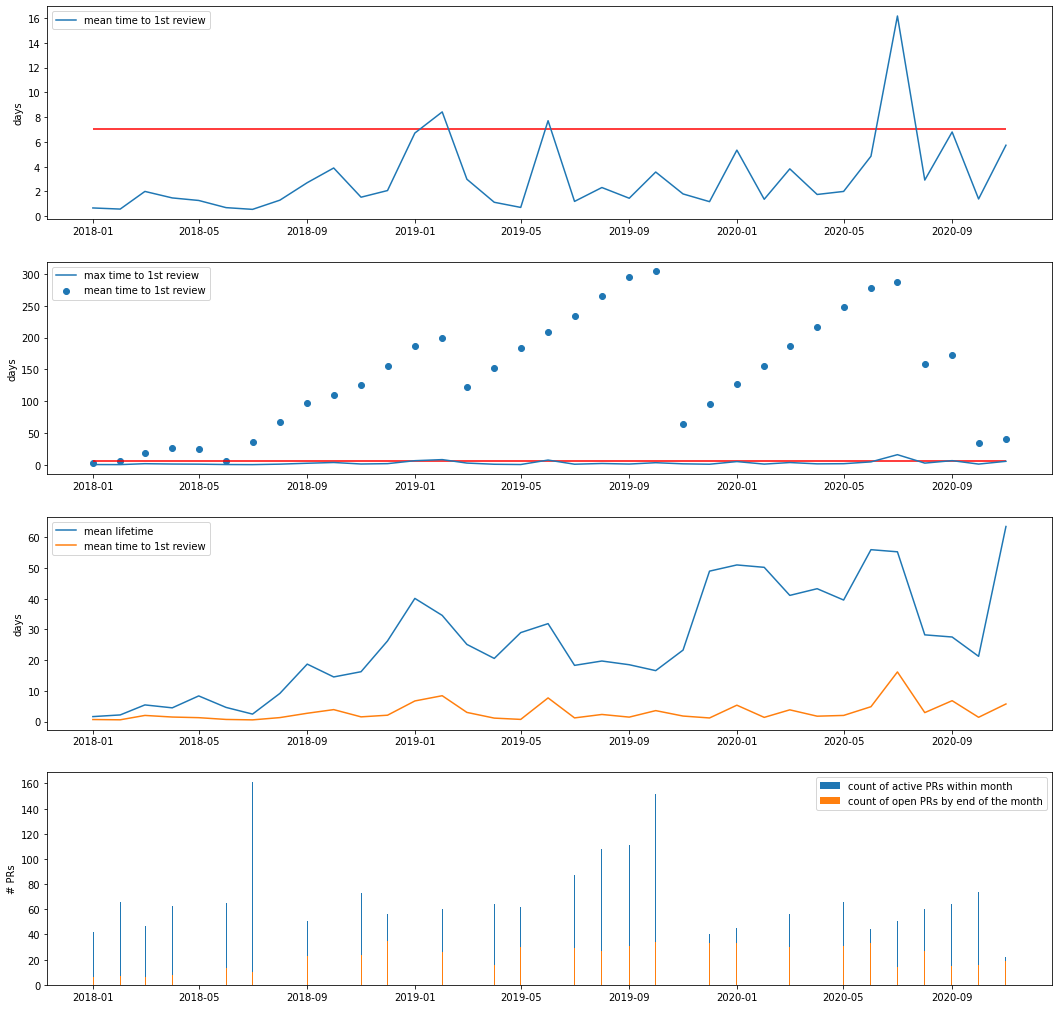

In [226]:
import matplotlib.pyplot as plt 

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(18,18))

ax1.set_ylabel('days')
# ax1.plot(months, mean_lifetime)
# ax1.scatter(months, review_maxs)
ax1.plot(months, mean_time_unreviewed)
ax1.hlines(y=7, color='red', xmin=months[0], xmax=months[-1])
ax1.legend(['mean time to 1st review'])


ax2.set_ylabel('days')
# ax1.plot(months, mean_lifetime)
ax2.plot(months, mean_time_unreviewed)
ax2.scatter(months, review_maxs)
ax2.hlines(y=7, color='red', xmin=months[0], xmax=months[-1])
ax2.legend(['max time to 1st review', 'mean time to 1st review'])

ax3.set_ylabel('days')
ax3.plot(months, mean_lifetime)
ax3.plot(months, mean_time_unreviewed)
ax3.legend(['mean lifetime', 'mean time to 1st review'])


ax4.set_ylabel('# PRs')

ax4.bar(months, counts)
ax4.bar(months, count_opens)


ax4.legend(['count of active PRs within month', 'count of open PRs by end of the month'])

plt.savefig("image.png", padding=0)